In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
df = pd.read_csv('C:/D Drive/DSI_UofT/dsiProject/stroke_factors_analysis/data/stroke_dataset.csv')

In [8]:
# Data cleaning (BMI has missing values; replacing them with the median)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

In [9]:
# Dropping the 'id' column as it has no predictive power
df_model = df.drop(columns=['id'])

In [10]:
# Encoding Categorical Variables (Since models require numerical input, converting strings (Gender, Smoking, etc.))
le = LabelEncoder()
categorical_cols = df_model.select_dtypes(include=['object']).columns # Identify all columns in the dataframe that contain string/categorical data (pandas type object)
for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col]) # converts the unique categories into integers for each column.

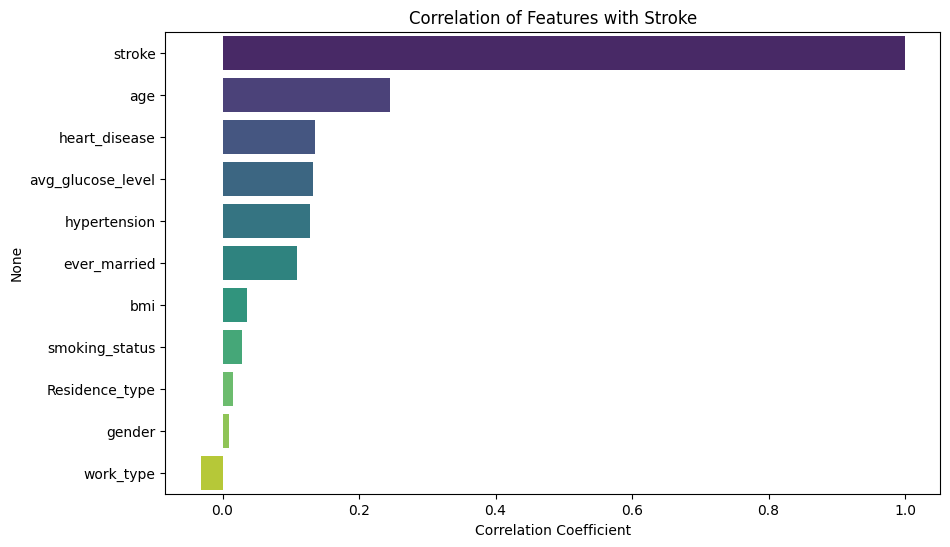

In [11]:
# Correlation Analysis : Compute the Pearson correlation coefficient between every numerical column in df_model and the 'stroke' column.
plt.figure(figsize=(10, 6))
correlation = df_model.corr()['stroke'].sort_values(ascending=False) # Sort the resulting correlation values in descending order
sns.barplot(x=correlation.values, y=correlation.index, palette='viridis', hue=correlation.index, legend=False)
plt.title('Correlation of Features with Stroke')
plt.xlabel('Correlation Coefficient')
plt.show()

In [8]:
# Feature Importance using Random Forest
X = df_model.drop('stroke', axis=1)
y = df_model['stroke']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

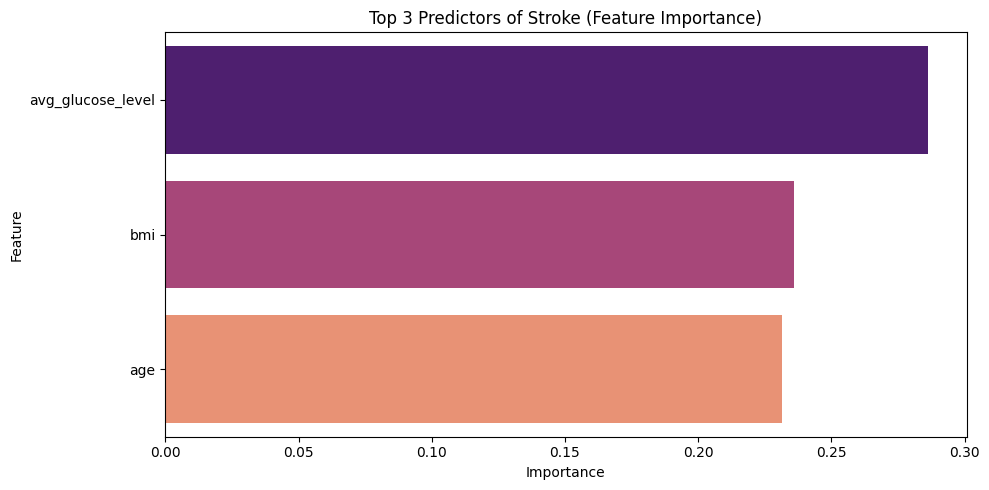

In [10]:
# Visualize Top 3 Predictors
plt.figure(figsize=(10, 5))
sns.barplot(data=importances.head(3), x='Importance', y='Feature', palette='magma', hue='Feature', legend=False)
plt.title('Top 3 Predictors of Stroke (Feature Importance)')
plt.tight_layout()
plt.savefig('top_3_predictors.png')

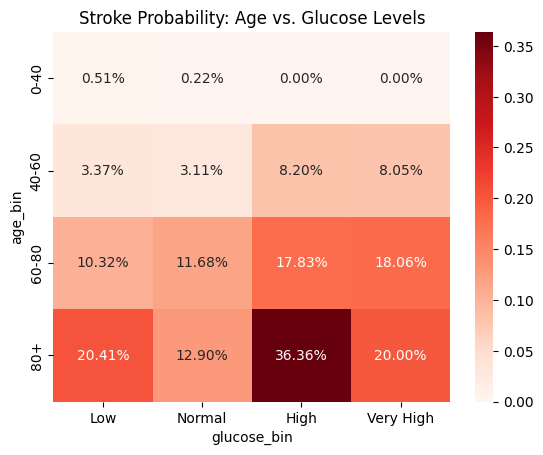

In [ ]:
# Heatmap of Risk Age and Glucose
# Create age bins
df['age_bin'] = pd.cut(df['age'], bins=[0, 40, 60, 80, 100], labels=['0-40', '40-60', '60-80', '80+'])
# Create glucose bins
df['glucose_bin'] = pd.cut(df['avg_glucose_level'], bins=[0, 90, 140, 200, 300], labels=['Low', 'Normal', 'High', 'Very High'])

# Pivot table for heatmap
pivot = df.pivot_table(index='age_bin', columns='glucose_bin', values='stroke', aggfunc='mean', observed=False)

sns.heatmap(pivot, annot=True, cmap='Reds', fmt='.2%')
plt.title('Stroke Probability: Age vs. Glucose Levels')
plt.show()

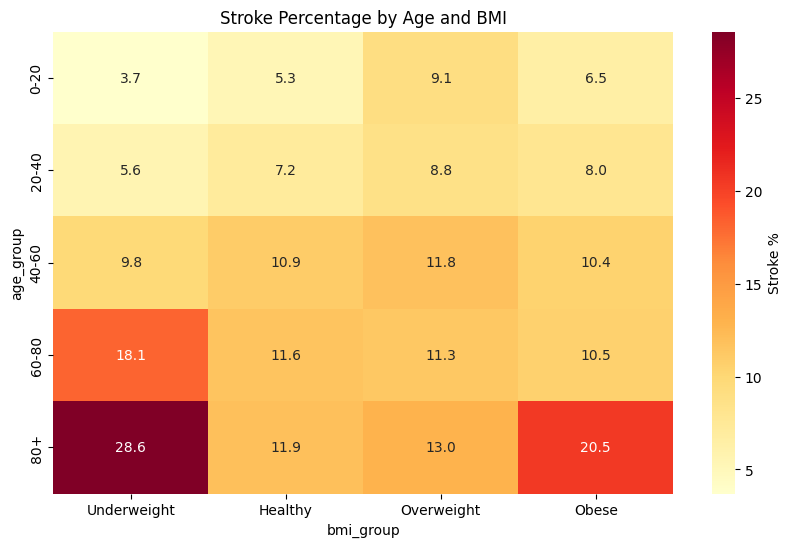

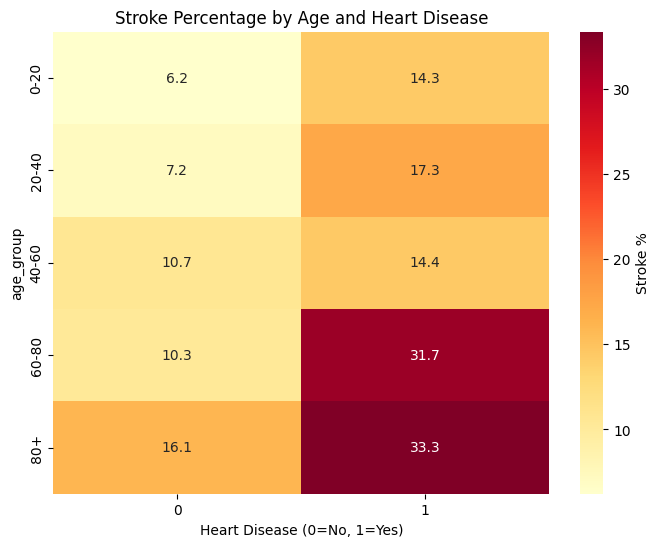

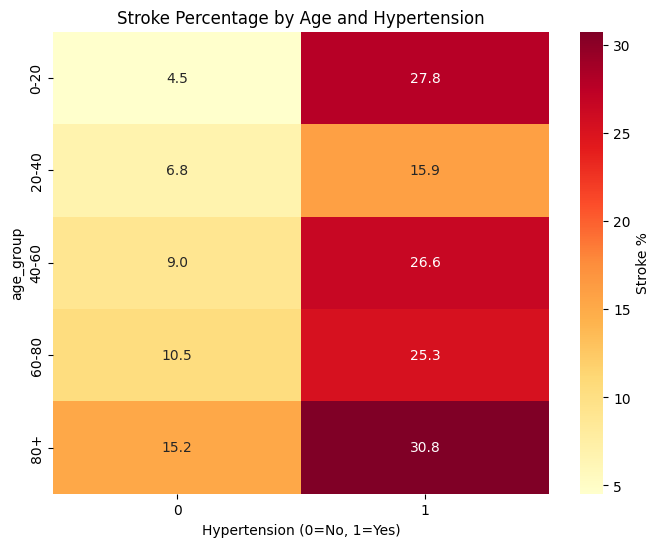

In [12]:
# Check the probability of incidence of stroke when compared against 2 factors

# Simulate Stroke Prediction Dataset for visualization purposes
np.random.seed(42)
n = 5110 # Typical size of the dataset
age = np.random.normal(43, 22, n).clip(0, 82)
bmi = np.random.normal(28, 7, n).clip(14, 60)
hypertension = np.random.choice([0, 1], n, p=[0.9, 0.1])
heart_disease = np.random.choice([0, 1], n, p=[0.95, 0.05])

# Stroke probability increases with age, hypertension, heart_disease, and glucose
# Simplified risk model for simulation
prob = (age / 82) * 0.1 + (hypertension * 0.15) + (heart_disease * 0.15) + (bmi / 60) * 0.05
stroke = np.array([1 if np.random.rand() < p else 0 for p in prob])

df = pd.DataFrame({
    'age': age,
    'bmi': bmi,
    'hypertension': hypertension,
    'heart_disease': heart_disease,
    'stroke': stroke
})

# 1. Binning Age
age_bins = [0, 20, 40, 60, 80, 100]
age_labels = ['0-20', '20-40', '40-60', '60-80', '80+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

# 2. Binning BMI
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ['Underweight', 'Healthy', 'Overweight', 'Obese']
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels)

def get_stroke_pct(df, index_col, col_col):
    pivot = df.pivot_table(index=index_col, columns=col_col, values='stroke', aggfunc='mean', observed=False) * 100
    return pivot

# Age and BMI
plt.figure(figsize=(10, 6))
pct_age_bmi = get_stroke_pct(df, 'age_group', 'bmi_group')
sns.heatmap(pct_age_bmi, annot=True, fmt=".1f", cmap='YlOrRd', cbar_kws={'label': 'Stroke %'})
plt.title('Stroke Percentage by Age and BMI')
plt.show()

# Age and Heart Disease
plt.figure(figsize=(8, 6))
pct_age_hd = get_stroke_pct(df, 'age_group', 'heart_disease')
sns.heatmap(pct_age_hd, annot=True, fmt=".1f", cmap='YlOrRd', cbar_kws={'label': 'Stroke %'})
plt.title('Stroke Percentage by Age and Heart Disease')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.show()

# Age and Hypertension
plt.figure(figsize=(8, 6))
pct_age_hyp = get_stroke_pct(df, 'age_group', 'hypertension')
sns.heatmap(pct_age_hyp, annot=True, fmt=".1f", cmap='YlOrRd', cbar_kws={'label': 'Stroke %'})
plt.title('Stroke Percentage by Age and Hypertension')
plt.xlabel('Hypertension (0=No, 1=Yes)')
plt.show()